# Symphony
## Quick start (<5 min) PBMCs tutorial

Last updated August 30, 2021

In this example, we will construct a reference from two pbmc datasets from 2 technologies (10x 3'v1 and 3'v2), then map a third dataset from a new technology (10x 5') with Symphony.

In [1]:
# Install Symphony from CRAN
install.packages('symphony')

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
suppressPackageStartupMessages({
    source('libs.R') # imports
    source('utils.R') # color definitions and plotting functions
})

## Get the data
If you would like to follow along, we provide the files `exprs_norm_all.rds` and `meta_data_subtypes.csv` in the `data` directory.

In [3]:
# Read in normalized expression and metadata
exprs_norm = readRDS('data/exprs_norm_all.rds')
metadata = read.csv('data/meta_data_subtypes.csv', row.names = 1)

dim(exprs_norm)
dim(metadata)

[1] 33694 20886

[1] 20886     8

In [4]:
metadata %>% head(4)

,cell_id,donor,nUMI,nGene,percent_mito,cell_type,res_0.80,cell_subtype
,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<int>,<chr>
threepfresh_AAACCTGAGCATCATC,threepfresh_AAACCTGAGCATCATC,3'V2,2394,871,0.03842941,bcells,3,bnaive
threepfresh_AAACCTGAGCTAACTC,threepfresh_AAACCTGAGCTAACTC,3'V2,1694,806,0.05726092,mono,5,mono14
threepfresh_AAACCTGAGCTAGTGG,threepfresh_AAACCTGAGCTAGTGG,3'V2,4520,1316,0.01946903,tcells,2,cd4mem
threepfresh_AAACCTGCACATTAGC,threepfresh_AAACCTGCACATTAGC,3'V2,2788,898,0.01398852,tcells,1,cd4naive


Subset dataset into reference and query

In [5]:
idx_query = which(metadata$donor == "5'") # use 5' dataset as the query
ref_exp_full = exprs_norm[, -idx_query]
ref_metadata = metadata[-idx_query, ]
query_exp = exprs_norm[, idx_query]
query_metadata = metadata[idx_query, ]

# Build Symphony Reference

There are two options for how to build a Symphony reference. Option 1 (`buildReferenceFromHarmonyObj`) is the more modular option, meaning that the user has more control over the preprocessing steps prior to reference compression. Option 2 (`buildReference`) builds a reference starting from expression, automating the procedure more but offering less flexibility. 

We'll demonstrate both options below.

## Option 1: Build from Harmony object (preferred method)
This option consists of more steps than Option 2 but allows your code to be more modular and flexible if you want to do your own preprocessing steps before the Harmony integration step. We recommend this option for most users.

It is important to generate `vargenes_means_sds` (containing variable gene means and standard deviations used to scale the genes) as well as save the loadings for the PCA step. 

In [6]:
# Sparse matrix with the normalized genes x cells matrix
ref_exp_full[1:5, 1:2]

5 x 2 sparse Matrix of class "dgCMatrix"
             threepfresh_AAACCTGAGCATCATC threepfresh_AAACCTGAGCTAACTC
RP11-34P13.3                            .                            .
FAM138A                                 .                            .
OR4F5                                   .                            .
RP11-34P13.7                            .                            .
RP11-34P13.8                            .                            .

Select variable genes and subset reference expression by variable genes

In [7]:
var_genes = vargenes_vst(ref_exp_full, groups = as.character(ref_metadata[['donor']]), topn = 2000)
ref_exp = ref_exp_full[var_genes, ]
dim(ref_exp)

[1]  3451 13189

Calculate and save the mean and standard deviations for each gene

In [8]:
vargenes_means_sds = tibble(symbol = var_genes, mean = Matrix::rowMeans(ref_exp))
vargenes_means_sds$stddev = singlecellmethods::rowSDs(ref_exp, vargenes_means_sds$mean)
head(vargenes_means_sds)

symbol,mean,stddev
<chr>,<dbl>,<dbl>
LYZ,1.796387,1.907826
HLA-DRA,1.904308,1.708515
CD74,2.555970,1.536484
S100A9,1.609852,1.849555
S100A4,2.502325,1.459852
FTL,3.579920,1.180329


Scale data using calculated gene means and standard deviations

In [9]:
ref_exp_scaled = singlecellmethods::scaleDataWithStats(ref_exp, vargenes_means_sds$mean, vargenes_means_sds$stddev, 1)

Run SVD, save gene loadings (s$u)

In [10]:
set.seed(0)
s = irlba(ref_exp_scaled, nv = 20)
Z_pca_ref = diag(s$d) %*% t(s$v) # [pcs by cells]
loadings = s$u

Run Harmony integration

In [11]:
set.seed(0)
ref_harmObj = harmony::HarmonyMatrix(
        data_mat = t(Z_pca_ref),  ## PCA embedding matrix of cells
        meta_data = ref_metadata, ## dataframe with cell labels
        theta = c(2),             ## cluster diversity enforcement
        vars_use = c('donor'),    ## variable to integrate out
        nclust = 100,             ## number of clusters in Harmony model
        max.iter.harmony = 20,
        return_object = TRUE,     ## return the full Harmony model object
        do_pca = FALSE            ## don't recompute PCs
)

Harmony 1/20

Harmony 2/20

Harmony 3/20

Harmony 4/20

Harmony 5/20

Harmony 6/20

Harmony 7/20

Harmony 8/20

Harmony 9/20

Harmony 10/20

Harmony 11/20

Harmony 12/20

Harmony 13/20

Harmony 14/20

Harmony 15/20

Harmony converged after 15 iterations



To run the next function `buildReferenceFromHarmonyObj()`, you need to input the saved gene loadings (`loadings`) and `vargenes_means_sds`.

In [12]:
# Compress a Harmony object into a Symphony reference
reference = symphony::buildReferenceFromHarmonyObj(
                           ref_harmObj,            # output object from HarmonyMatrix()
                           ref_metadata,           # reference cell metadata
                           vargenes_means_sds,     # gene names, means, and std devs for scaling
                           loadings,               # genes x PCs matrix
                           verbose = TRUE,         # verbose output
                           do_umap = TRUE,         # Set to TRUE only when UMAP model was saved for reference
                           save_uwot_path = './testing_uwot_model_1')

Save metadata, vargenes (S), and loadings (U)

Save R, Z_orig, Z_corr, and betas from Harmony object

Calculate final L2 normalized reference centroids (Y_cos)

Calculate reference compression terms (Nr and C)

UMAP

Warning message:
“invalid uid value replaced by that for user 'nobody'”
Saved uwot model

Finished nicely.



In [13]:
# Optionally, you can specify which normalization method was
# used to build the reference as a custom slot inside the Symphony object to 
# help record this information for future query users
reference$normalization_method = 'log(CP10k+1)'

Save Symphony reference (modify with your desired output path)

In [14]:
saveRDS(reference, './testing_reference1.rds')

Let's take a look at what the reference object contains:
- meta_data: metadata
- vargenes: variable genes, means, and standard deviations used for scaling
- loadings: gene loadings for projection into pre-Harmony PC space
- R: Soft cluster assignments
- Z_orig: Pre-Harmony PC embedding
- Z_corr: Harmonized PC embedding
- centroids: locations of final Harmony soft cluster centroids
- cache: pre-calculated reference-dependent portions of the mixture model
- umap: UMAP coordinates
- save_uwot_path: path to saved uwot model (for query UMAP projection into reference UMAP coordinates)
- normalization_method: type of normalization used

In [15]:
str(reference)

List of 13
 $ meta_data           :'data.frame':	13189 obs. of  8 variables:
  ..$ cell_id     : chr [1:13189] "threepfresh_AAACCTGAGCATCATC" "threepfresh_AAACCTGAGCTAACTC" "threepfresh_AAACCTGAGCTAGTGG" "threepfresh_AAACCTGCACATTAGC" ...
  ..$ donor       : chr [1:13189] "3'V2" "3'V2" "3'V2" "3'V2" ...
  ..$ nUMI        : int [1:13189] 2394 1694 4520 2788 4667 4440 3224 5205 5493 4419 ...
  ..$ nGene       : int [1:13189] 871 806 1316 898 1526 1495 1253 1433 1632 1134 ...
  ..$ percent_mito: num [1:13189] 0.0384 0.0573 0.0195 0.014 0.0362 ...
  ..$ cell_type   : chr [1:13189] "bcells" "mono" "tcells" "tcells" ...
  ..$ res_0.80    : int [1:13189] 3 5 2 1 0 0 6 4 0 4 ...
  ..$ cell_subtype: chr [1:13189] "bnaive" "mono14" "cd4mem" "cd4naive" ...
 $ vargenes            : tibble [3,451 × 3] (S3: tbl_df/tbl/data.frame)
  ..$ symbol: chr [1:3451] "LYZ" "HLA-DRA" "CD74" "S100A9" ...
  ..$ mean  : Named num [1:3451] 1.8 1.9 2.56 1.61 2.5 ...
  .. ..- attr(*, "names")= chr [1:3451] "LYZ" "HLA

The harmonized embedding is located in the `Z_corr` slot of the reference object.

In [16]:
dim(reference$Z_corr)
reference$Z_corr[1:5, 1:5]

[1]    20 13189

,threepfresh_AAACCTGAGCATCATC,threepfresh_AAACCTGAGCTAACTC,threepfresh_AAACCTGAGCTAGTGG,threepfresh_AAACCTGCACATTAGC,threepfresh_AAACCTGCACTGTTAG
harmony_1,2.667665,-12.1324995,3.601084,5.2540710,-16.69439470
harmony_2,12.270629,-0.1023444,-3.114944,-0.4249402,0.10716277
harmony_3,-4.075378,2.5144215,2.992201,4.3451417,-0.14392359
harmony_4,-1.980770,-0.5718973,-3.118918,-2.4868374,-2.54940462
harmony_5,1.210151,2.6643824,-1.546548,0.4824211,-0.05278061


Visualize reference UMAP

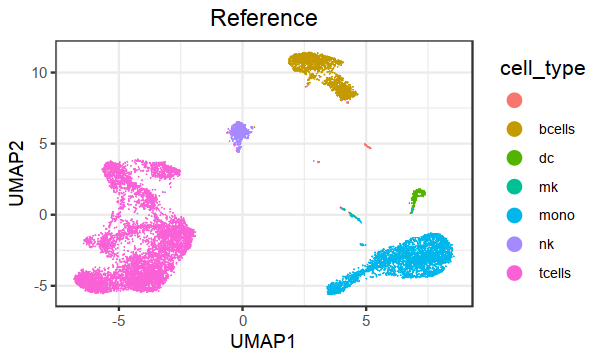

In [17]:
reference = readRDS('./testing_reference1.rds')

umap_labels = cbind(ref_metadata, reference$umap$embedding)

fig.size(3, 5)
plotBasic(umap_labels, title = 'Reference', color.by = 'cell_type')

## Option 2: Build from scratch (starting with expression)

This option computes a reference object starting from expression in a unified pipeline, automating the preprocessing steps.

In [18]:
# Build reference
set.seed(0)
reference = symphony::buildReference(
    ref_exp_full,
    ref_metadata,
    vars = c('donor'),         # variables to integrate over
    K = 100,                   # number of Harmony clusters
    verbose = TRUE,            # verbose output
    do_umap = TRUE,            # can set to FALSE if want to run umap separately later
    do_normalize = FALSE,      # set to TRUE if input counts are not normalized yet
    vargenes_method = 'vst',   # method for variable gene selection ('vst' or 'mvp')
    vargenes_groups = 'donor', # metadata column specifying groups for variable gene selection 
    topn = 2000,               # number of variable genes to choose per group
    d = 20,                    # number of PCs
    save_uwot_path = './testing_uwot_model_2'
)

reference$normalization_method = 'log(CP10k+1)' # optionally save normalization method in custom slot

# Save reference (modify with your desired output path)
saveRDS(reference, './testing_reference2.rds')

Finding variable genes using vst method

Total 3451 genes for downstream steps

Scaling and PCA

Running Harmony integration

Harmony 1/20

Harmony 2/20

Harmony 3/20

Harmony 4/20

Harmony 5/20

Harmony 6/20

Harmony 7/20

Harmony 8/20

Harmony 9/20

Harmony 10/20

Harmony 11/20

Harmony 12/20

Harmony converged after 12 iterations

Computing reference compression terms

Running UMAP

Warning message:
“invalid uid value replaced by that for user 'nobody'”
Saved uwot model



Visualize reference UMAP

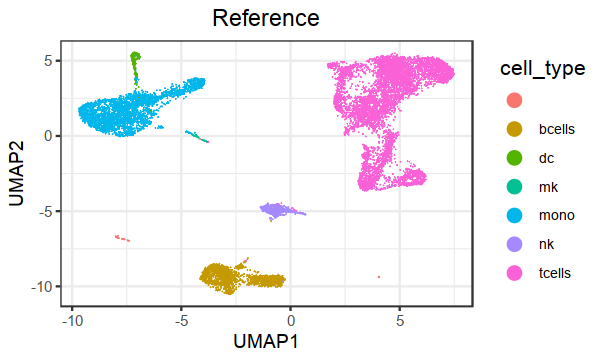

In [19]:
reference = readRDS('./testing_reference2.rds')

umap_labels = cbind(ref_metadata, reference$umap$embedding)

fig.size(3, 5)
plotBasic(umap_labels, title = 'Reference', color.by = 'cell_type')

# Map query

In order to map a new query dataset onto the reference, you will need a reference object saved from the steps above, as well as query cell expression and metadata.

The query dataset is assumed to have been normalized in the same manner as the reference cells (here, default is log(CP10k+1) normalization).

In [20]:
# Read in Symphony reference to map to
reference = readRDS('./testing_reference1.rds')

In [21]:
# Map query
query = mapQuery(query_exp,             # query gene expression (genes x cells)
                 query_metadata,        # query metadata (cells x attributes)
                 reference,             # Symphony reference object
                 do_normalize = FALSE,  # perform log(CP10k+1) normalization on query
                 do_umap = TRUE)        # project query cells into reference UMAP

Scaling and synchronizing query gene expression

Found 3451 out of 3451 reference variable genes in query dataset

Project query cells using reference gene loadings

Clustering query cells to reference centroids

Correcting query batch effects

UMAP

All done!



Note: Symphony assumes that the query is normalized in the same manner as the reference. Our implementation currently uses log(CP10k) normalization.

Let's take a look at what the query object contains:
- Z: query cells in reference Harmonized embedding
- Zq_pca: query cells in pre-Harmony reference PC embedding (prior to correction)
- R: query cell soft cluster assignments
- Xq: query cell design matrix for correction step
- umap: query cells projected into reference UMAP coordinates (using uwot)
- meta_data: metadata

In [22]:
str(query)

List of 7
 $ exp      :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. ..@ i       : int [1:13735662] 45 59 72 110 139 153 160 197 211 242 ...
  .. ..@ p       : int [1:7698] 0 1318 3482 5594 7120 8452 10450 11318 12889 14154 ...
  .. ..@ Dim     : int [1:2] 33694 7697
  .. ..@ Dimnames:List of 2
  .. .. ..$ : chr [1:33694] "RP11-34P13.3" "FAM138A" "OR4F5" "RP11-34P13.7" ...
  .. .. ..$ : chr [1:7697] "fivePrime_AAACCTGAGCGATAGC" "fivePrime_AAACCTGAGCTAAACA" "fivePrime_AAACCTGAGGGAGTAA" "fivePrime_AAACCTGAGTCTTGCA" ...
  .. ..@ x       : num [1:13735662] 1.54 1.54 2.13 1.54 1.54 ...
  .. ..@ factors : list()
 $ meta_data:'data.frame':	7697 obs. of  8 variables:
  ..$ cell_id     : chr [1:7697] "fivePrime_AAACCTGAGCGATAGC" "fivePrime_AAACCTGAGCTAAACA" "fivePrime_AAACCTGAGGGAGTAA" "fivePrime_AAACCTGAGTCTTGCA" ...
  ..$ donor       : chr [1:7697] "5'" "5'" "5'" "5'" ...
  ..$ nUMI        : int [1:7697] 2712 6561 6322 4528 3426 6199 2378 4934 3654 12842 ...
  ..$ nGene       

Predict query cell types using k-NN

In [23]:
query = knnPredict(query, reference, reference$meta_data$cell_type, k = 5)

Query cell type predictions are now in the `cell_type_pred_knn` column. The `cell_type_pred_knn_prob` column reports the proportion of nearest neighbors with the winning vote (can help identify query cells that fall "on the border" between 2 reference cell types).

In [25]:
head(query$meta_data)

,cell_id,donor,nUMI,nGene,percent_mito,cell_type,res_0.80,cell_subtype,cell_type_pred_knn,cell_type_pred_knn_prob
,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<int>,<chr>,<fct>,<dbl>
fivePrime_AAACCTGAGCGATAGC,fivePrime_AAACCTGAGCGATAGC,5',2712,1318,0.06637168,nk,9,nk,nk,1
fivePrime_AAACCTGAGCTAAACA,fivePrime_AAACCTGAGCTAAACA,5',6561,2164,0.05654626,mono,0,mono14,mono,1
fivePrime_AAACCTGAGGGAGTAA,fivePrime_AAACCTGAGGGAGTAA,5',6322,2112,0.05615312,mono,0,mono14,mono,1
fivePrime_AAACCTGAGTCTTGCA,fivePrime_AAACCTGAGTCTTGCA,5',4528,1526,0.07199647,tcells,11,cd8eff,tcells,1
fivePrime_AAACCTGAGTTCGATC,fivePrime_AAACCTGAGTTCGATC,5',3426,1332,0.06830123,mono,0,mono14,mono,1
fivePrime_AAACCTGCACACTGCG,fivePrime_AAACCTGCACACTGCG,5',6199,1998,0.05097596,bcells,8,bmem,bcells,1


## Visualization of mapping

In [27]:
# Sync the column names for both data frames
reference$meta_data$cell_type_pred_knn = NA
reference$meta_data$cell_type_pred_knn_prob = NA
reference$meta_data$ref_query = 'reference'
query$meta_data$ref_query = 'query'

# Add the UMAP coordinates to the metadata
meta_data_combined = rbind(query$meta_data, reference$meta_data)
umap_combined = rbind(query$umap, reference$umap$embedding)
umap_combined_labels = cbind(meta_data_combined, umap_combined)

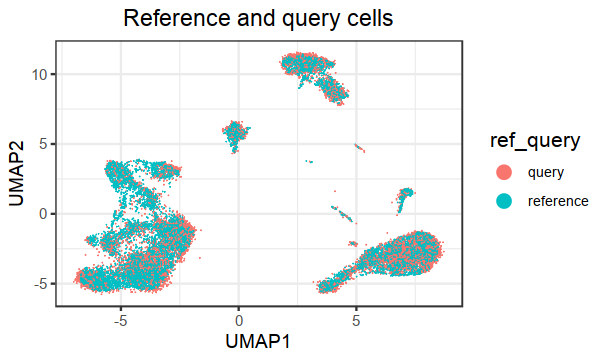

In [28]:
# Plot UMAP visualization of all cells
fig.size(3, 5)
plotBasic(umap_combined_labels, title = 'Reference and query cells', color.by = 'ref_query')

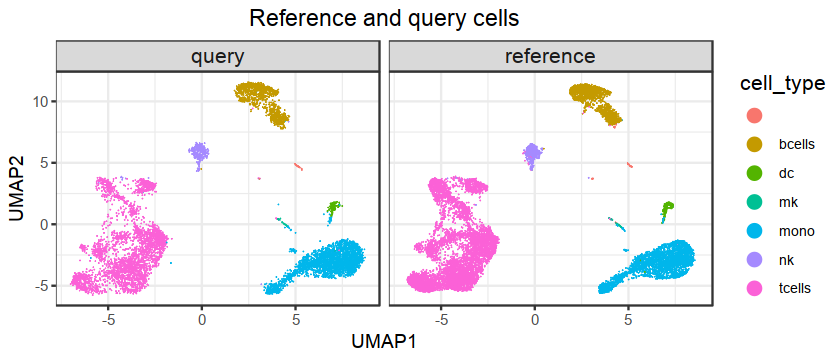

In [29]:
fig.size(3, 7)
plotBasic(umap_combined_labels, title = 'Reference and query cells', 
          color.by = 'cell_type', facet.by = 'ref_query')

In [30]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/jbk37/anaconda3/envs/seurat4/lib/libopenblasp-r0.3.15.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggpubr_0.4.0            patchwork_1.1.1         RColorBrewer_1.1-2     
 [4] ggrastr_0.2.3           ggthemes_4.2.4          plyr_1.8.6             
 [7] matrixStats_0.59.0      forcats_0.5.1           stringr_1.4.0          
[10] dplyr_1.0.7             purrr_

And that's a wrap! If you run into issues or have questions about Symphony or this tutorial, please open an issue on GitHub.